# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
from reed import *
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0'

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all.pkl"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv("all_vars.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              }
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              }
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':[10,20,40,60,80],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
# %load -s exclude_vars,seperate_and_transform_data direct_regression.py
def exclude_vars():
    """Return a list of variables that should not be included as features."""
    treatments = ['^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$']
    outcomes = ['^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_']
    other = [
        '^p_rcom',
        '^p_rdf',
        '^p_cotrl',
        '^xwaveid$',
        'p_rcom18'  # ?
        '^aedcq',  # indicate studying at start - these people should already have been removed
        '^abnfsty',
        '^aedcqfpt',
        '^aedqstdy'
    ]
    exclude = treatments + outcomes + other
    return exclude

def seperate_and_transform_data(data, treatment, outcome):

    transform = Pipeline([
        ('impute_missing', SimpleImputer()),
        ('scale', StandardScaler()),
    ])

    exclude = exclude_vars()

    control, treated = treatment_control_split(data, treatment)
    features = regex_select(data.columns, exclude, exclude=True)
    X0, y0 = split_and_transform(control, features, outcome, transform)
    X1, y1 = split_and_transform(treated, features, outcome, transform)

    # construct the full dataset (remove ordering by treatment in case of any order dependance in fit)
    X = np.vstack((X0, X1))
    y = np.concatenate((y0, y1))
    indx = np.arange(len(y))
    np.random.shuffle(indx)
    X = X[indx, :]
    y = y[indx]

    return X0, X1, y0, y1, X, y, features


In [6]:
X0, X1, y0, y1, X, y, features = seperate_and_transform_data(data, treatment, outcome)
print("Number of features:",len(features))

Treated:1295, Control:3659
Number of features: 638


### Compute unconditional/unadjusted estimate of treatment effect

In [7]:
# %load -s print_unconditional_effects direct_regression.py
def print_unconditional_effects(data, treatment, y0, y1):
    print(f"Proportion Treated:{100*data[treatment].mean():.0f}%")
    print(f"Average outcome under Control:{y0.mean():.2f}±{y0.std()/np.sqrt(len(y0)):.2f}")
    print(f"Average outcome under Treatment:{y1.mean():.2f}±{y1.std()/np.sqrt(len(y1)):.2f}")
    print(f"Unadjusted treatment estimate {y1.mean() - y0.mean():.2f}")


In [8]:
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.37
Average outcome under Treatment:310.57±29.40
Unadjusted treatment estimate 242.72


### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

In [9]:
# %load -s nested_cross_val direct_regression.py
def nested_cross_val(
    construct_models,
    cache_name,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=None,
    outercv=None,
    load_from_cache=False,
):
    if load_from_cache:
        with open(cache_name, 'rb') as f:
            models, results = pickle.load(f)

    else:
        models = construct_models()
        results = {}
        for model in models:
            print(f"Fitting {model.name} ...", end='')
            results0 = model.nested_cv_fit_evaluate(
                X0, y0, optimisation_metric, evaluation_metrics,
                inner_cv=innercv, outer_cv=outercv)
            results1 = model.nested_cv_fit_evaluate(
                X1, y1, optimisation_metric, evaluation_metrics,
                inner_cv=innercv, outer_cv=outercv)
            results[model.name] = (results0, results1)
            print("Done")

        print(f"Caching results to {cache_name}")
        with open(cache_name, 'wb') as f:
            pickle.dump((models, results), f)

    return models, results


In [10]:
models, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=3,
    outercv=5,
    load_from_cache=False)

Fitting ridge ...Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Done
Fitting lasso ...Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.694e+07, tolerance: 6.768e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.489e+07, tolerance: 6.768e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.567e+04, tolerance: 7.775e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.739e+04, tolerance: 7.775e+04
  model = cd_fast.enet_coordinate_descent(


Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.219e+07, tolerance: 8.023e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+08, tolerance: 9.031e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+05, tolerance: 3.819e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.973e+05, tolerance: 2.281e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+05, tolerance: 3.455e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+05, tolerance: 3.455e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+04, tolerance: 3.455e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.652e+04, tolerance: 3.455e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Done
Fitting gbr ...Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[CV] END ...........................alpha=0.4893900918477494; total time=   0.1s
[CV] END ...........................alpha=11.721022975334806; total time=   0.1s
[CV] END ...........................alpha=188.73918221350976; total time=   0.1s
[CV] END ...........................alpha=2043.3597178569437; total time=   0.1s
[CV] END ..........................alpha=0.14873521072935114; total time=   0.1s
[CV] END ............................alpha=2.395026619987486; total time=   0.1s
[CV] END ............................alpha=25.92943797404667; total time=   0.1s
[CV] END ............................alpha=25.92943797404667; total time=   0.1s
[CV] END ...........................alpha=2043.3597178569437; total time=   0.1s
[CV] END ..........................alpha=0.14873521072935114; total time=   0.1s
[CV] END ...........................alpha=1.6102620275609392; total time=   0.0s
[CV] END ................

[CV] END ...........................alpha=0.4893900918477494; total time=   0.1s
[CV] END ............................alpha=38.56620421163472; total time=   0.1s
[CV] END ...........................alpha=417.53189365604044; total time=   0.1s
[CV] END .............................alpha=4520.35365636025; total time=   0.1s
[CV] END ..........................alpha=0.32903445623126687; total time=   0.1s
[CV] END ...........................alpha=1.0826367338740546; total time=   0.1s
[CV] END ............................alpha=17.43328822199989; total time=   0.1s
[CV] END ............................alpha=17.43328822199989; total time=   0.1s
[CV] END ............................alpha=3039.195382313201; total time=   0.1s
[CV] END ...........................alpha=0.2212216291070449; total time=   0.0s
[CV] END ............................alpha=2.395026619987486; total time=   0.0s
[CV] END ...........................alpha=57.361525104486816; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.14873521072935114; total time=   0.1s
[CV] END ...........................alpha=1.0826367338740546; total time=   0.1s
[CV] END .............................alpha=5.29831690628371; total time=   0.1s
[CV] END ............................alpha=25.92943797404667; total time=   0.1s
[CV] END ...........................alpha=280.72162039411785; total time=   0.1s
[CV] END ............................alpha=3039.195382313201; total time=   0.1s
[CV] END ...........................alpha=0.2212216291070449; total time=   0.1s
[CV] END ............................alpha=2.395026619987486; total time=   0.1s
[CV] END ............................alpha=923.6708571873866; total time=   0.1s
[CV] END ............................alpha=923.6708571873866; total time=   0.1s
[CV] END ......................................alpha=10000.0; total time=   0.0s
[CV] END ...........................alpha=0.7278953843983151; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.14873521072935114; total time=   0.1s
[CV] END ...........................alpha=1.6102620275609392; total time=   0.1s
[CV] END .............................alpha=5.29831690628371; total time=   0.1s
[CV] END ...........................alpha=57.361525104486816; total time=   0.1s
[CV] END ............................alpha=621.0169418915616; total time=   0.1s
[CV] END .............................alpha=4520.35365636025; total time=   0.1s
[CV] END ..........................alpha=0.32903445623126687; total time=   0.1s
[CV] END ............................alpha=7.880462815669913; total time=   0.1s
[CV] END ...........................alpha=126.89610031679234; total time=   0.1s
[CV] END ...........................alpha=126.89610031679234; total time=   0.1s
[CV] END ...........................alpha=2043.3597178569437; total time=   0.1s
[CV] END ..........................alpha=0.14873521072935114; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.7278953843983151; total time=   0.1s
[CV] END ............................alpha=85.31678524172814; total time=   0.1s
[CV] END ............................alpha=923.6708571873866; total time=   0.1s
[CV] END ......................................alpha=10000.0; total time=   0.1s
[CV] END ...........................alpha=0.4893900918477494; total time=   0.1s
[CV] END .............................alpha=5.29831690628371; total time=   0.1s
[CV] END ............................alpha=621.0169418915616; total time=   0.1s
[CV] END ............................alpha=621.0169418915616; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ...........................alpha=1.0826367338740546; total time=   0.0s
[CV] END ............................alpha=17.43328822199989; total time=   0.0s
[CV] END ............................alpha=17.43328822199989; total time=   0.0s
[CV] END ...................

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=21; total time=   0.4s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=10; total time=   0.2s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=100; total time=   0.2s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=10; total time=   0.4s


[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=4; total time=   0.3s[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=46; total time=   0.4s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=46; total time=   0.2s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=1; total time=   0.2s
[CV] END learn

[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=46; total time=   0.4s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=4; total time=   0.2s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1; total time=   0.2s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=46; total time=   0.1s
[CV] END learn

[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=2; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=2; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=215; total time=   0.4s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, mi

[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=100; total time=   0.2s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=10; total time=   0.4s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=1000; tota

[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=10; total time=   0.2s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=215; total time=   0.4s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learn

[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=1; total time=   0.1

[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=21; total time=   0.2s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=46; total time=   0.4s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=46; total time=   0.2s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=21; total time=   0.4s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=4; total time=   0.1

[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=10; total time=   0.2s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=2; total time=   0.5s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=2; total time=   

[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=215; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=2; total time=   0.3s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=46; total time=   0.2s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=46; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=46; total time=   0.2s
[CV] END learnin

[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=46; total time=   0.2s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=2; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=2; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=1; total time=   0.2s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=2; total time= 

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=2; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=215; total time=   0.0s
[CV] END learning

[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=1; total time=   0.0s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=1; total time=   0.1s
[CV] END l

[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=100; total time=   0.1s[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=21; total time=   0.2s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=21; total time=   0.2s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=4; total time=   0.2s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=10;

[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=100; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=100; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=464

[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=21; total time=   0.0s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=2; total time=   0.1s
[CV] END learning_

[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=1; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=1; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=2; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=2; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=21; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=21; total time=   0.0s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=21; total time=   0.0s
[CV] END learning_rate=1.0

Done
Caching results to data/cross-val-all.pkl


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

In [11]:
def estimate_causal_effect(X, models0, models1):
    tau = []
    for e0, e1 in zip(models0,models1):
        y0 = e0.predict(X)
        y1 = e1.predict(X)
        tau.append(y1-y0)
    
    # array of shape len(modelsi),len(X)
    cate = np.array(tau) 
    
    # array of shape len(modelsi) with the ate estimate for each sample
    ate = np.mean(cate,axis=1) 
    return ate

rows = []
index = []
for model_name, r in results.items():
    tau = estimate_causal_effect(X, r[0]['estimator'],r[1]['estimator'])
    row = {'ACE':tau.mean(),'ACE_std':tau.std()}
    for m in evaluation_metrics:
        key = f'test_{m}'
        for name, result in zip(('control','treated'),r):
            label=f"{name}_{m}"
            label_std=f"{label}_std"
            row[label]= result[key].mean()
            std = result[key].std()
            row[label_std] = result[key].std()
    rows.append(row)
    index.append(model_name)
metrics = pd.DataFrame(rows,index=index)

with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(metrics)

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,243.29,35.23,0.17,0.01,0.18,0.00,"-718,713.88","50,003.13","-921,719.15","148,236.61"
lasso,242.53,28.37,0.17,0.01,0.20,0.00,"-715,955.30","51,734.64","-892,417.56","137,147.08"
gbr,272.82,1.45,0.24,0.03,0.14,0.02,"-657,288.57","24,122.49","-958,849.72","168,213.35"


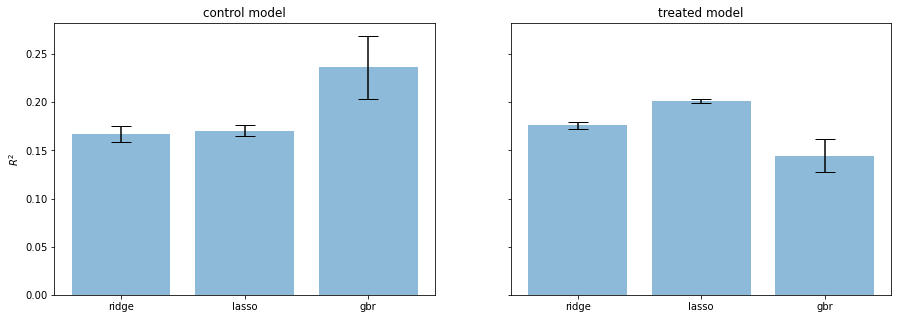

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
ax[0].bar(metrics.index, metrics['control_r2'], yerr=metrics['control_r2_std'], align='center', alpha=0.5, capsize=10)
ax[1].bar(metrics.index, metrics['treated_r2'], yerr=metrics['treated_r2_std'], align='center', alpha=0.5,capsize=10)
ax[0].set_ylabel('$R^2$')
ax[0].set_title('control model')
ax[1].set_title('treated model');

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [13]:
def get_coef(estimator):
    e = estimator
    if hasattr(estimator,'best_estimator_'):
        e = estimator.best_estimator_
    if hasattr(e,'coef_'):
        return e.coef_
    return None 

def coef_mean_std(estimator_lst):
    n_estimators = len(estimator_lst)
    coef = np.zeros((len(features),n_estimators))
    for i, e in enumerate(estimator_lst):
        coef[:,i] = get_coef(e)
    mu = coef.mean(axis=1)
    std = coef.std(axis=1)
    return mu, std

def display_top_coefficients(model_name, r):
    if get_coef(r[0]['estimator'][0]) is None:
        return
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
    
    contr, treat = r[0], r[1]
    coef_t_mu, coef_t_std = coef_mean_std(treat['estimator'])
    coef_c_mu, coef_c_std = coef_mean_std(contr['estimator'])
    coefs = pd.DataFrame({
        'feature':features,
        'coef0':coef_c_mu,
        'coef1':coef_t_mu
    })
    absv = np.vstack((coefs['coef0'].abs().values,coefs['coef1'].abs().values)).T
    coefs['importance'] = absv.max(axis=1)
    coefs['hetero'] = (coefs['coef1']-coefs['coef0']).abs()
    labels = coefs['feature'].apply(meta.column_names_to_labels.get)
    coefs.insert(0,'variable',labels)
    print(f'Feature Coefficients for: {model_name}')
    display(coefs.sort_values('importance',ascending=False).head(20))


In [14]:
for model_name, r in results.items():
    display_top_coefficients(model_name,r)

Feature Coefficients for: ridge


,variable,feature,coef0,coef1,importance,hetero
189,DV: Current weekly gross wages & salary - all ...,awscei,-52.534358,-61.473803,61.473803,8.939445
163,DV: Age last birthday at June 30 2001,ahgage,-34.253227,-37.611777,37.611777,3.358549
132,DV: Household current weekly gross wages & sal...,ahiwscmi,-36.807938,-27.627626,36.807938,9.180312
249,D2 Years since left full-time education,aehtseyr,-31.101625,-35.488778,35.488778,4.387154
250,D3a1 Years in paid work,aehtjbyr,-32.359158,-32.389751,32.389751,0.030593
302,G3 Total gross amount of most recent pay befor...,awscmga,-31.203121,-22.687071,31.203121,8.516051
276,E29 Percent chance will find and accept job at...,ajbmpgj,30.052857,5.873159,30.052857,24.179698
363,H27 How likely to have a child/more children i...,aicexpct,28.385272,9.987988,28.385272,18.397284
3,DV: Age last birthday at June 30 2001 - person 01,ahgage1,-24.545983,-25.924074,25.924074,1.378090
442,DV: Tenure with current employer (years),ajbempt,-25.690504,-10.181539,25.690504,15.508965


Feature Coefficients for: lasso


,variable,feature,coef0,coef1,importance,hetero
189,DV: Current weekly gross wages & salary - all ...,awscei,-139.701559,-253.113182,253.113182,113.411623
163,DV: Age last birthday at June 30 2001,ahgage,-166.865653,-138.924794,166.865653,27.940859
249,D2 Years since left full-time education,aehtseyr,-5.565896,-115.054209,115.054209,109.488313
363,H27 How likely to have a child/more children i...,aicexpct,69.208705,0.000000,69.208705,69.208705
54,Q1 Any children aged 14 or less,acccinhh,-54.996889,-2.002482,54.996889,52.994407
326,G28bi Financial year dividends ($) [weighted t...,aoifdiva,0.000000,-46.828583,46.828583,46.828583
276,E29 Percent chance will find and accept job at...,ajbmpgj,34.346165,0.000000,34.346165,34.346165
352,H15b Age of child - Resident child 0002,arcage2,-30.736767,0.000000,30.736767,30.736767
302,G3 Total gross amount of most recent pay befor...,awscmga,-25.805737,0.000000,25.805737,25.805737
145,DV: Imputation flag household financial year b...,ahibiff,0.000000,-25.223348,25.223348,25.223348


### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

In [16]:
def extract_params(estimator):
    return estimator.coef_

def bootstrapped_cross_val(
    optimisation_metric,
    extract_params_func,
    inner_cv = 3,
    load_from_cache=False, 
    cache_name=bootstrap_cache, 
    samples=1
):
    if load_from_cache:
        with open(cache_name, 'rb') as f:
            results = pickle.load(f)
    else:
        models = construct_models()
        results = {}
        start = time.time()
        for model in models:
            print(f"Fitting {model.name} ...",end='')
            results0 = model.bootstrap_cv_evaluate(X0,y0,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results1 = model.bootstrap_cv_evaluate(X1,y1,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results[model.name] = (results0, results1)
            print("Done")
        total = time.time()-start
        print(f"Total time:{total} seconds")
        print(f"Caching results to: {cache_name}")
        with open(cache_name,'wb') as f:
            pickle.dump(results,f)
    
    return results

bootstrap_results = bootstrapped_cross_val(
    optimisation_metric, 
    extract_params,
    load_from_cache=False,
    inner_cv=3,
    samples=100
)

Fitting ridge ...Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END learning_rate=0.46415888336127775, max_features=80, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=21; total time=   0.0s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=0.001, max_features=10, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.001, max_featur

Done
Fitting lasso ...Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.901e+08, tolerance: 2.286e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.922e+08, tolerance: 2.521e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e+07, tolerance: 2.521e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+06, tolerance: 2.521e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=4; total time=   0.2s
[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=10; total time=   0.2s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_fea


[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=1; total time=   0.2s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=2; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=2; total time=   0.2s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+08, tolerance: 1.867e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.430e+08, tolerance: 2.338e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e+07, tolerance: 2.338e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.028e+06, tolerance: 1.867e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.443e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=100; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=100; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=215; total time=  

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+06, tolerance: 8.272e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e+06, tolerance: 1.024e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e+05, tolerance: 1.024e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.745e+05, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.226e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e+06, tolerance: 1.226e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.598e+06, tolerance: 1.226e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+07, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf

[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=4; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=4; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=10; total time=   0.1s
[CV] END learni

[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=21; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=21; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=46; total time=   0.0s
[CV] END learning_rate=1.0, max_features=10, min_samples_leaf=1; total time=   0.0s
[CV] E

[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=100; total time=   0.0s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=100; total time=   0.0s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=215; total time=   0.0s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=1; total time=   0.0s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=1; total time=   0.0s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=2; total time=   0.0s
[CV] END learning_rate=1.0, max_features=60, min_samples_leaf=2; total time=   0.0s
[CV] END ..........................alpha=0.14873521072935114; total time=   0.3s
[CV] END ..........................

[CV] END ............................alpha=52.98316906283707; total time=   0.4s
[CV] END ............................alpha=137.3823795883264; total time=   1.1s
[CV] END ............................alpha=923.6708571873866; total time=   0.1s
[CV] END ............................alpha=2395.026619987486; total time=   0.1s
[CV] END ......................................alpha=10000.0; total time=   0.1s
[CV] END ..........................alpha=0.02592943797404667; total time=   4.9s
[CV] END ..........................alpha=0.10826367338740546; total time=   4.6s
[CV] END ............................alpha=0.727895384398315; total time=   5.8s
[CV] END ...........................alpha=12.689610031679221; total time=   0.9s
[CV] END ............................alpha=32.90344562312668; total time=   0.3s
[CV] END ............................alpha=85.31678524172806; total time=   0.3s
[CV] END ............................alpha=137.3823795883264; total time=   0.2s
[CV] END ...................

[CV] END ............................alpha=2395.026619987486; total time=   0.1s
[CV] END ......................................alpha=10000.0; total time=   0.1s
[CV] END .........................................alpha=0.01; total time=   5.2s
[CV] END ...........................alpha=0.2807216203941177; total time=   5.0s
[CV] END ...........................alpha=1.8873918221350976; total time=   1.7s
[CV] END ............................alpha=3.039195382313198; total time=   1.6s
[CV] END ............................alpha=4.893900918477494; total time=   1.0s
[CV] END ............................alpha=7.880462815669913; total time=   3.6s
[CV] END ............................alpha=0.041753189365604; total time=   1.5s
[CV] END ..........................alpha=0.17433288221999882; total time=   1.6s
[CV] END ...........................alpha=1.8873918221350976; total time=   1.7s
[CV] END ............................alpha=7.880462815669913; total time=   0.4s
[CV] END ...................

[CV] END ............................alpha=7.880462815669913; total time=   0.8s
[CV] END ............................alpha=85.31678524172806; total time=   0.1s
[CV] END ...........................alpha=221.22162910704503; total time=   0.1s
[CV] END ............................alpha=923.6708571873866; total time=   0.0s
[CV] END ............................alpha=2395.026619987486; total time=   0.0s
[CV] END ......................................alpha=10000.0; total time=   0.0s
[CV] END learning_rate=0.001, max_features=10, min_samples_leaf=2; total time=   0.3s
[CV] END learning_rate=0.001, max_features=10, min_samples_leaf=46; total time=   0.3s
[CV] END learning_rate=0.001, max_features=10, min_samples_leaf=464; total time=   0.3s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=10; total time=   0.5s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=215; total time=   0.4s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=2; total time=

[CV] END learning_rate=0.0021544346900318843, max_features=20, min_samples_leaf=100; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=40, min_samples_leaf=1; total time=   0.8s
[CV] END learning_rate=0.0021544346900318843, max_features=40, min_samples_leaf=21; total time=   0.8s
[CV] END learning_rate=0.0021544346900318843, max_features=40, min_samples_leaf=464; total time=   0.7s
[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=10; total time=   1.1s
[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=215; total time=   1.0s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=2; total time=   1.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=46; total time=   1.4s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_

[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=10; total time=   1.3s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=215; total time=   1.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=2; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=10; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=2; total time=   0.5s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=464; total time=   0.5s
[CV] END learning_rate=0.004641588833612777, max_features=40, min_samples_leaf=10; total time=   0.8s
[CV] END learning_rate=0.004641588833612777, max_features=40, min_samples_leaf=

[CV] END learning_rate=0.004641588833612777, max_features=60, min_samples_leaf=1000; total time=   0.6s
[CV] END learning_rate=0.004641588833612777, max_features=80, min_samples_leaf=4; total time=   1.4s
[CV] END learning_rate=0.004641588833612777, max_features=80, min_samples_leaf=100; total time=   1.4s
[CV] END learning_rate=0.01, max_features=10, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.01, max_features=10, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=0.01, max_features=10, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.01, max_features=10, min_samples_leaf=464; total time=   0.3s
[CV] END learning_rate=0.01, max_features=20, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.01, max_features=20, min_samples_leaf=100; total time=   0.5s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=1; total time=   0.8s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=21; total time=   0.7s
[CV] E

[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=4; total time=   0.5s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=100; total time=   0.5s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=1; total time=   0.8s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=46; total time=   0.8s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=1000; total time=   0.4s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=2; total time=   1.1s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=46; total time=   1.1s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=1; total time=   1.0s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=21; total time=   1.4s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=464;

[CV] END learning_rate=0.046415888336127774, max_features=10, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=10, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=4; total time=   0.5s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=100; total time=   0.5s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=1; total time=   0.8s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=46; total time=   0.8s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=1000; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=4; total time=   1.1s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=46; total time=   0.6s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=46

[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=46; total time=   0.8s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=1000; total time=   0.5s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=4; total time=   1.2s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=215; total time=   1.1s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=2; total time=   1.5s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=46; total time=   1.5s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=1000; total time=   0.8s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=46; total time=   0.3s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=1000; total time=   0.2s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=4; total time=   0.5s
[CV] END learning_rate=0.1,

[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=4; total time=   0.8s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=100; total time=   0.8s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=1; total time=   1.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=21; total time=   1.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=1000; total time=   0.6s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=10; total time=   1.4s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=215; total time=   1.4s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=46; total time=   0.3s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=1000; total 

[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=1000; total time=   0.4s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=2; total time=   1.2s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=215; total time=   0.7s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=464; total time=   1.0s
[CV] END learning_rate=0.46415888336127775, max_features=80, min_samples_leaf=10; total time=   1.4s
[CV] END learning_rate=0.46415888336127775, max_features=80, min_samples_leaf=464; total time=   1.2s
[CV] END learning_rate=1.0, max_features=10, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=1.0, max_features=10, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=1.0, max_features=20, min

[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=21; total time=   0.8s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=1; total time=   1.1s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=21; total time=   0.8s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=464; total time=   0.9s
[CV] END learning_rate=0.46415888336127775, max_features=80, min_samples_leaf=4; total time=   1.4s
[CV] END learning_rate=0.46415888336127775, max_features=80, min_samples_leaf=100; total time=   1.3s
[CV] END learning_rate=1.0, max_features=10, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=1.0, max_features=10, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=1.0, max_features=10, min_samples_leaf=464; total time=   0.2s
[CV] END learning_rate=1.0, max_features=20, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=1.0, max_features=20, min_sample

[CV] END learning_rate=0.0021544346900318843, max_features=20, min_samples_leaf=1; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=20, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=20, min_samples_leaf=464; total time=   0.4s
[CV] END learning_rate=0.0021544346900318843, max_features=40, min_samples_leaf=10; total time=   0.8s
[CV] END learning_rate=0.0021544346900318843, max_features=40, min_samples_leaf=215; total time=   0.8s
[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=2; total time=   1.1s
[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=46; total time=   1.1s
[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=1000; total time=   0.6s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=4; total time=   1.4s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_sampl

[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=464; total time=   0.9s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=10; total time=   1.4s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=215; total time=   1.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=2; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=10; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=2; total time=   0.5s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=46; total time=   0.5s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=464; total time=   0.4s
[CV] END learning_rate=0.004641588833612777, max_features=40, min_samples_lea

[CV] END learning_rate=0.004641588833612777, max_features=60, min_samples_leaf=4; total time=   1.1s
[CV] END learning_rate=0.004641588833612777, max_features=60, min_samples_leaf=100; total time=   1.1s
[CV] END learning_rate=0.004641588833612777, max_features=60, min_samples_leaf=1000; total time=   0.6s
[CV] END learning_rate=0.004641588833612777, max_features=80, min_samples_leaf=4; total time=   1.5s
[CV] END learning_rate=0.004641588833612777, max_features=80, min_samples_leaf=46; total time=   1.4s
[CV] END learning_rate=0.004641588833612777, max_features=80, min_samples_leaf=1000; total time=   0.8s
[CV] END learning_rate=0.01, max_features=10, min_samples_leaf=10; total time=   0.3s
[CV] END learning_rate=0.01, max_features=10, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.01, max_features=20, min_samples_leaf=1; total time=   0.5s
[CV] END learning_rate=0.01, max_features=20, min_samples_leaf=46; total time=   0.5s
[CV] END learning_rate=0.01, max_features

[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=10; total time=   0.3s
[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=1; total time=   0.5s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=464; total time=   0.4s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=10; total time=   0.8s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=215; total time=   0.8s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=2; total time=   1.1s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=46; total time=   1.4s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=1;

[CV] END learning_rate=0.046415888336127774, max_features=10, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=1; total time=   0.5s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=464; total time=   0.5s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=10; total time=   0.9s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=215; total time=   0.8s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=2; total time=   1.3s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=46; total time=   1.3s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=1000; total time=   0.8s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=

[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=1; total time=   0.9s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=21; total time=   0.8s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=464; total time=   0.7s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=10; total time=   0.5s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=21; total time=   1.1s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=464; total time=   1.0s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=4; total time=   1.3s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=100; total time=   1.5s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=10; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=10, min_samples_leaf=215; total time=   0.3s
[CV] END learnin

[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=10; total time=   1.1s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=215; total time=   1.0s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=1; total time=   1.4s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=21; total time=   1.4s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=1000; total time=   0.3s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=464; total t

[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=4; total time=   1.4s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=215; total time=   0.4s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=464; total time=   1.2s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=100; total time=   0.2s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=1000; total time=   0.2s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=10; total time=   0.6s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=215; total time=   0.5s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=10; total time=   0.5s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=46; total

[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=215; total time=   0.3s[CV] END learning_rate=1.0, max_features=80, min_samples_leaf=46; total time=   1.4s
[CV] END learning_rate=0.001, max_features=10, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.001, max_features=10, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=4; total time=   0.2s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=4; total time=   0.2s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.001

[CV] END learning_rate=0.001, max_features=20, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=10; total time=   0.4s
[CV] END learning_rate=0.0021544346900318843, max_features=10, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.0021544346900318843, max_features=10, min_samples_leaf=10; total time=   0.1s
[CV] END

[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.0021544346900318843, max_features=60, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=1; total time=   0.4s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=46; total time=   0.4s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=1; total time=   0.1s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_sampl

[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=10; total time=   0.4s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=10, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=4; total time=   0.2s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=100; total time=   0.2s
[CV] END learning_rate=0.004641588833612777, max_features=20, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.004641588833612777, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.004641588833612777, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.004641588833612777, max_features=60, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.004641588833612777, max_features=60, min_samples_

[CV] END learning_rate=0.01, max_features=20, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=215; total time=   0.1s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.01, max_features=40, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=1; total time=   0.4s
[CV] END learning_rate=0.01, max_features=80

[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.01, max_features=60, min_samples_leaf=21; total time=   0.4s
[CV] END learning_rate=0.01, max_features=80, min_samples_leaf=2; total time=   0.4s
[CV] END learning_rate=0.01, max_features=80, min_samples_leaf=2; total time=   0.4s
[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=10, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=100; total time=   0.2s
[CV] END learning_rate=0.021544346900318832, max_features=20, min_samples_leaf=100; total time=   0.2s
[CV] END learning_rate=0.021544346900318

[CV] END learning_rate=0.046415888336127774, max_features=10, min_samples_leaf=215; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.046415888336127774, max_features=20, min_samples_leaf=215; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.046415888336127774, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=2; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=60, min_samples_leaf=2; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=21; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=80, min_samples_leaf=21; total time=   0.4s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=100; total time= 


[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.1, max_features=10, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=1; total time=   0.2s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=2; total time=   0.2s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=20, min_samples_leaf=1000; total time=   0.0s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=10; total time=   0.3s
[CV] END learning_rate=0.1, max_features=40, min_samples_leaf=10; total time=   0.3s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.1, max_features=60, min_samples_leaf=46; total time=   0.3s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=21; total time=   0.4s
[CV] END learning_rate=0.1, max_features=80, min_samples_leaf=46

[CV] END learning_rate=0.21544346900318823, max_features=20, min_samples_leaf=21; total time=   0.2s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=40, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=60, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=10; total time=   0.4s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=100; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=100; tot

[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=1; total time=   0.5s
[CV] END learning_rate=0.21544346900318823, max_features=80, min_samples_leaf=1; total time=   0.5s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=10, min_samples_leaf=10; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=4; total time=   0.1s
[CV] END learning_rate=0.46415888336127775, max_features=20, min_samples_leaf=10; total time=   0.2s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=1; total time=   0.3s
[CV] END learning_rate=0.46415888336127775, max_features=40, min_samples_leaf=2; total time=   0.2s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=21; total time=   0.3s
[CV] END learning_rate=0.46415888336127775, max_features=60, min_samples_leaf=21; total time=   0

[CV] END learning_rate=0.001, max_features=40, min_samples_leaf=2; total time=   0.3s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=100; total time=   0.3s
[CV] END learning_rate=0.001, max_features=60, min_samples_leaf=215; total time=   0.3s
[CV] END learning_rate=0.0021544346900318843, max_features=10, min_samples_leaf=21; total time=   0.1s
[CV] END learning_rate=0.0021544346900318843, max_features=10, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.0021544346900318843, max_features=10, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.0021544346900318843, max_features=10, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.0021544346900318843, max_features=40, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=0.0021544346900318843, ma

[CV] END learning_rate=0.001, max_features=80, min_samples_leaf=100; total time=   0.4s
[CV] END learning_rate=0.001, max_features=80, min_samples_leaf=100; total time=   0.4s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=10; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=10; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=21; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=46; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=46; total time=   0.5s
[CV] END learning_rate=0.0021544346900318843, max_features=80, min_samples_leaf=46; total time=   0.6s


[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=4; total time=   0.3s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=215; total time=   0.2s
[CV] END learning_rate=0.021544346900318832, max_features=40, min_samples_leaf=464; total time=   0.0s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=2; total time=   0.3s
[CV] END learning_rate=0.021544346900318832, max_features=60, min_samples_leaf=46; total time=   0.3s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=4; total time=   0.4s
[CV] END learning_rate=0.021544346900318832, max_features=80, min_samples_leaf=100; total time=   0.4s
[CV] END learning_rate=0.046415888336127774, max_features=10, min_samples_leaf=2; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=10, min_samples_leaf=46; total time=   0.1s
[CV] END learning_rate=0.046415888336127774, max_features=10, min_samples_leaf=1000

####  Average treatment effects

In [17]:
for model_name, (results0, results1) in bootstrap_results.items():
    models0 = [r['estimator'] for r in results0]
    models1 = [r['estimator'] for r in results1]
    ate = estimate_causal_effect(X,models0, models1)
    print(f'{model_name}, {ate.mean():.2f} ± {ate.std()/np.sqrt(len(ate)-1):.2f}')  

ridge, 223.68 ± 11.08
lasso, 267.64 ± 0.95
gbr, 255.25 ± 5.81


#### Distribution of hyper-parameters

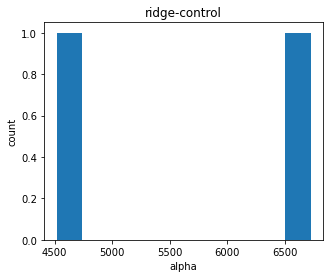

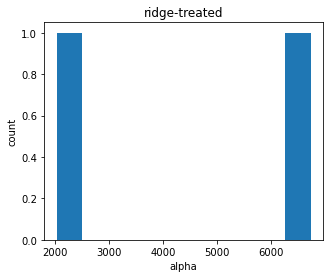

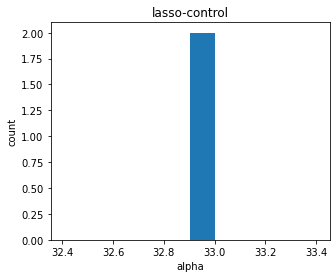

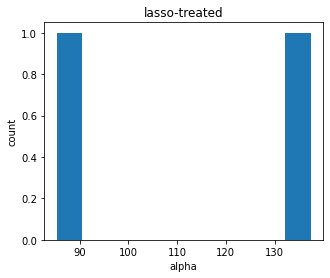

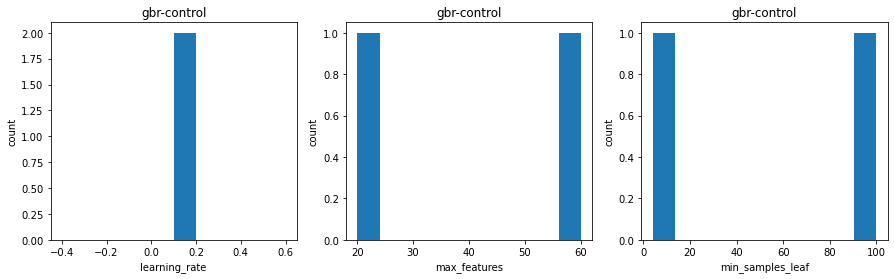

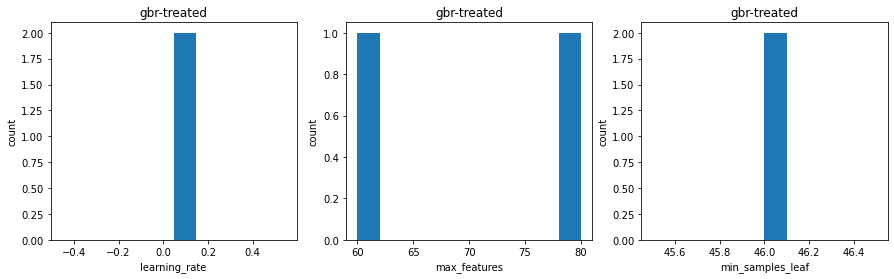

In [18]:
from collections import defaultdict
def hyperparam_distributions(samples) -> {str:[]}:
    """Returns a dict from hyper-parameter name to the best values for that hyper-parameter over the samples."""
    distributions = defaultdict(list)
    for sample in samples:
        h = sample['estimator'].best_params_
        for key, value in h.items():
            distributions[key].append(value)
    return distributions

def plot_hyperparam_distributions(samples, title) -> None:
    distributions = hyperparam_distributions(samples)
    k = len(distributions)
    fig, axes = plt.subplots(1,k,figsize=(k*5,4))
    if k == 1:
        axes = [axes]
    for i, (key, values) in enumerate(distributions.items()):
        ax = axes[i]
        ax.hist(values)
        ax.set_title(title)
        ax.set_xlabel(key)
        ax.set_ylabel('count')
    return fig,axes

for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")